## Import Libraries

In [2]:
'''basics'''
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import pickle5 as pickle
import numpy as np

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB


'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')


## Import data and holdout data for prediction

In [10]:
df = pd.read_json('../data/processed/encoded_labels/main_strategies_all.json')
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'capacity_building', 'enabling', 'finance_economy',
       'food_and_agricultural_commodities', 'governance', 'law_regulation',
       'management_operation', 'mitigation_adaptation', 'monitor_inventory',
       'technology_innovation', 'category_1', 'category_2', 'category_3',
       'labels'],
      dtype='object')

In [11]:
df_labels = df.drop(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'category_1', 'category_2', 'category_3',
       'labels'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,capacity_building,377
1,enabling,84
2,finance_economy,162
3,food_and_agricultural_commodities,73
4,governance,240
5,law_regulation,240
6,management_operation,260
7,mitigation_adaptation,45
8,monitor_inventory,161
9,technology_innovation,75


Text(0.5, 0, 'category')

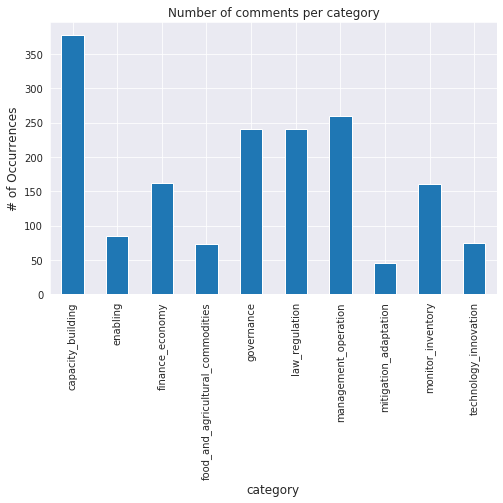

In [12]:
df_stats.plot(x='category', y='number_of_inputs', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

## How many comments have multi labels

Text(0.5, 0, '# of categories')

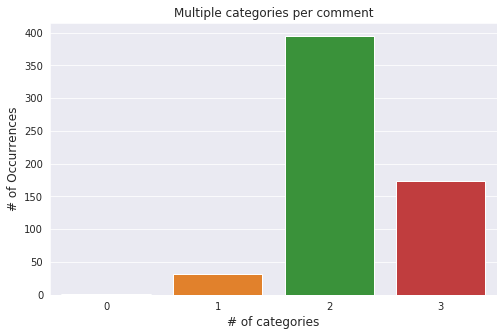

In [13]:
rowsums = df.iloc[:,4:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

## The distribution of the number of words in input texts

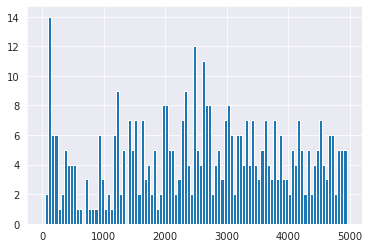

In [15]:
lens = df.all_text_clean.str.len()
lens.hist(bins = np.arange(0,5000,50))

## Holding out 5 rows from the original dataframe for prediction at the end

In [17]:
df_holdout = df.iloc[:5]

df = df.iloc[5:]

In [18]:
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy',
       'capacity_building', 'enabling', 'finance_economy',
       'food_and_agricultural_commodities', 'governance', 'law_regulation',
       'management_operation', 'mitigation_adaptation', 'monitor_inventory',
       'technology_innovation', 'category_1', 'category_2', 'category_3',
       'labels'],
      dtype='object')

##  Features engineering

In [19]:
categories = ['capacity_building', 'enabling', 'finance_economy',
       'food_and_agricultural_commodities', 'governance', 'law_regulation',
       'management_operation', 'mitigation_adaptation', 'monitor_inventory',
       'technology_innovation']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)


## Train multiple ML models / OneVsRest multi-label strategy

In [20]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]
#print (tabulate(rows, header, tablefmt='html'))


<table>
<thead>
<tr><th>Category                         </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>capacity_building                </td><td style="text-align: right;">      377</td><td>Random Forest    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Decsision Tree    
 K Nearest Neighbor    
 AdaBoost              </td><td>0.711864406779661    
 0.672316384180791    
 0.672316384180791    
 0.6666666666666666    
 0.672316384180791    
 0.6384180790960452                 </td><td>0.6836043360433605   
 0.6731358529111338   
 0.6459294436906378   
 0.6408526713437669   
 0.6374813710879285   
 0.6036602600339175                  </td><td>0.6697994987468672    
 0.6888053467000835    
 0.649749373433584    
 0.6453634085213033    
 0.6284461152882206    
 0.6021303258145363               </td><td>0.6744563453424214    
 0.6656461698801459    
 0.6474587912087911    
 0.6425221647896484    
 0.6313559322033899    
 0.6028050490883591           </td></tr>
<tr><td>enabling                         </td><td style="text-align: right;">       84</td><td>Stochastic Gradient Descent    
 K Nearest Neighbor    
 Random Forest    
 AdaBoost    
 Decsision Tree    
 Gaussian Naive Bayes              </td><td>0.903954802259887    
 0.9096045197740112    
 0.903954802259887    
 0.8870056497175142    
 0.864406779661017    
 0.7966101694915254                 </td><td>0.8325757575757575   
 0.8998015873015872   
 0.8550898203592814   
 0.7619606003752346   
 0.6925383077948034   
 0.6376434720229556                  </td><td>0.6859119141727837    
 0.6706662902315077    
 0.6674195369847544    
 0.6576792772444946    
 0.663184641445511    
 0.7166854884246189               </td><td>0.7304970891177788    
 0.7251552795031055    
 0.7159444916454262    
 0.6907756813417191    
 0.6758241758241758    
 0.6566810344827586           </td></tr>
<tr><td>finance_economy                  </td><td style="text-align: right;">      162</td><td>K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost    
 Gaussian Naive Bayes    
 Decsision Tree    
 Random Forest              </td><td>0.8248587570621468    
 0.7966101694915254    
 0.7966101694915254    
 0.7062146892655368    
 0.7062146892655368    
 0.751412429378531                 </td><td>0.8047283702213279   
 0.7491338582677165   
 0.7518518518518518   
 0.668090787716956   
 0.6322602057749751   
 0.7138364779874213                  </td><td>0.7385039370078741    
 0.7491338582677165    
 0.7248818897637795    
 0.6982677165354331    
 0.6255118110236221    
 0.5963779527559054               </td><td>0.7600262409796632    
 0.7491338582677165    
 0.7356455360106207    
 0.6722222222222222    
 0.6283914728682171    
 0.5995475113122172           </td></tr>
<tr><td>food_and_agricultural_commodities</td><td style="text-align: right;">       73</td><td>AdaBoost    
 Decsision Tree    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest              </td><td>0.8813559322033898    
 0.847457627118644    
 0.8757062146892656    
 0.7231638418079096    
 0.8813559322033898    
 0.8813559322033898                 </td><td>0.7592455621301775   
 0.6233567046450482   
 0.741860465116279   
 0.5496411483253588   
 0.9400000000000000   
 0.9400000000000000                  </td><td>0.5989553924336534    
 0.5794748729531338    
 0.5587238848108413    
 0.5820158102766798    
 0.5434782608695652    
 0.5434782608695652               </td><td>0.6287825826425647    
 0.5925483843464916    
 0.5734005258545135    
 0.5489625045504187    
 0.5480851063829787    
 0.5480851063829787           </td></tr>
<tr><td>governance                       </td><td style="text-align: right;">      240</td><td>Random Forest    
 Stochastic Gradient Descent    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 AdaBoost    
 Decsision Tree              </td><td>0.7627118644067796    
 0.7401129943502824    
 0.7457627118644068    
 0.7175141242937854    
 0.711864406779661    
 0.6779661016949152                 </td><td>0.7651315789473684   
 0.7334022216481529   
 0.7446392350043466   
 0.7116126543209876   
 0.7031941371681416   
 0.6669559412550067                  </td><td>0.7388698630136986    
 0.738013698630137    
 0.7224051633298209    
 0.7167413066385668    
 0.693559009483667    
 0.6647128556375133               </td><td>0.7447115384615385    
 0.734822824387702    
 0.7273474138226133    
 0.7126623376623376    
 0.6963570924013589    
 0.6656282106519074           </td></tr>
<tr><td>law_regulation                   </td><td style="text-align: right;">      240</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor    
 Decsision Tree    
 Gaussian Naive Bayes              </td><td>0.7231638418079096    
 0.6949152542372882    
 0.6779661016949152    
 0.6779661016949152    
 0.6610169491525424    
 0.672316384180791                 </td><td>0.7034252297410192   
 0.6717948717948719   
 0.6623529411764706   
 0.6590486314111081   
 0.6501932989690722   
 0.6485066371681416                  </td><td>0.6994266994266994    
 0.6646191646191646    
 0.6695331695331695    
 0.6633906633906634    
 0.6590909090909091    
 0.6466011466011465               </td><td>0.701188630490956    
 0.6672932330827067    
 0.6640695235241236    
 0.6606343973897542    
 0.6502897787144363    
 0.6474587912087912           </td></tr>
<tr><td>management_operation             </td><td style="text-align: right;">      260</td><td>K Nearest Neighbor    
 Random Forest    
 Stochastic Gradient Descent    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes              </td><td>0.8531073446327684    
 0.847457627118644    
 0.8305084745762712    
 0.8248587570621468    
 0.8192090395480226    
 0.7966101694915254                 </td><td>0.8513351134846462   
 0.8462157809983897   
 0.8254299114121939   
 0.8203371970495258   
 0.8139004689942678   
 0.7980842911877395                  </td><td>0.8452505903962215    
 0.8384938336394647    
 0.827735502492784    
 0.8190763579113094    
 0.8161243768039884    
 0.8062188401994228               </td><td>0.8478174603174602    
 0.8416133629403773    
 0.8264705882352941    
 0.8196785960761115    
 0.8149019607843138    
 0.7955070603337613           </td></tr>
<tr><td>mitigation_adaptation            </td><td style="text-align: right;">       45</td><td>Gaussian Naive Bayes    
 Decsision Tree    
 AdaBoost    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor              </td><td>0.807909604519774    
 0.8757062146892656    
 0.903954802259887    
 0.9265536723163842    
 0.9265536723163842    
 0.9152542372881356                 </td><td>0.600891861761427   
 0.5691358024691358   
 0.5924556213017751   
 0.7157142857142857   
 0.4632768361581921   
 0.46285714285714286                  </td><td>0.7546904315196998    
 0.5787992495309568    
 0.5586303939962476    
 0.5354127579737336    
 0.5    
 0.49390243902439024               </td><td>0.6167855323484461    
 0.5734005258545135    
 0.5697125697125698    
 0.5474926253687316    
 0.4809384164222874    
 0.4778761061946903           </td></tr>
<tr><td>monitor_inventory                </td><td style="text-align: right;">      161</td><td>AdaBoost    
 Random Forest    
 Stochastic Gradient Descent    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 Decsision Tree              </td><td>0.8700564971751412    
 0.8587570621468926    
 0.847457627118644    
 0.8248587570621468    
 0.7288135593220338    
 0.7570621468926554                 </td><td>0.8541058394160583   
 0.8565405183052242   
 0.8218065693430657   
 0.7928814842862553   
 0.6957323498419389   
 0.6973228346456692                  </td><td>0.8093909438775511    
 0.7763871173469388    
 0.7811702806122449    
 0.7466517857142857    
 0.7369260204081632    
 0.6997767857142857               </td><td>0.8273902904388382    
 0.8032721291068332    
 0.797371210515158    
 0.7637866460028413    
 0.6998304126625212    
 0.6985145573380868           </td></tr>
<tr><td>technology_innovation            </td><td style="text-align: right;">       75</td><td>Gaussian Naive Bayes    
 Decsision Tree    
 K Nearest Neighbor    
 AdaBoost    
 Random Forest    
 Stochastic Gradient Descent              </td><td>0.7570621468926554    
 0.8135593220338984    
 0.8700564971751412    
 0.847457627118644    
 0.864406779661017    
 0.847457627118644                 </td><td>0.6448494687131051   
 0.620096790626592   
 0.7719298245614035   
 0.6477272727272727   
 0.7672413793103448   
 0.555635838150289                  </td><td>0.7582894736842105    
 0.6240789473684211    
 0.5734210526315789    
 0.5769736842105263    
 0.5367105263157895    
 0.5101315789473684               </td><td>0.6558133224799891    
 0.6220151426907397    
 0.5934285428942374    
 0.5925483843464916    
 0.5346187554776513    
 0.49294429708222814           </td></tr>
</tbody>
</table>